In [ ]:
pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00


In [ ]:
#Connect Google Drive
from google.colab import drive
drive._mount('/content/drive')

ValueError: mount failed

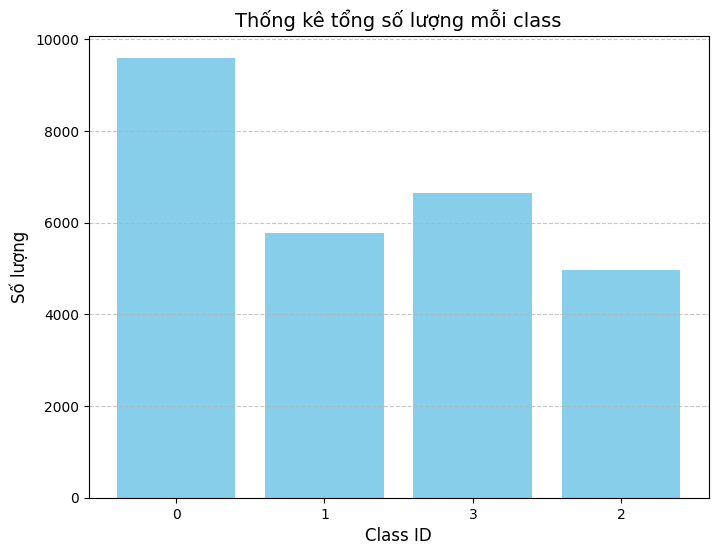

In [ ]:
import os
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục labels (YOLO format)
labels_folder = "/content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/labels/train"

# Tạo dictionary để lưu số lượng của từng class
class_counts = {}

# Duyệt qua tất cả file .txt trong thư mục YOLO labels
for filename in os.listdir(labels_folder):
    if filename.endswith('.txt'):
        label_path = os.path.join(labels_folder, filename)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Lấy class_id từ mỗi dòng nhãn YOLO
                class_id = int(line.strip().split()[0])  # Phần tử đầu tiên là class_id
                if class_id in class_counts:
                    class_counts[class_id] += 1
                else:
                    class_counts[class_id] = 1

# Vẽ biểu đồ thống kê
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.title('Thống kê tổng số lượng mỗi class', fontsize=14)
plt.xticks(range(len(class_counts)), [str(c) for c in class_counts.keys()])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import os
import shutil
import json
from PIL import Image
# Đường dẫn đến folder chứa ảnh và JSON
input_folder = "/content/drive/MyDrive/AIP491/Datasets/Augment_0327/augment_mixup_result"

# Đường dẫn lưu ảnh và nhãn YOLO
output_images_folder = "/content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/images/train"
output_labels_folder = "/content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/labels/train"

# Đảm bảo rằng thư mục output tồn tại
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

# Hàm chuyển đổi nhãn từ JSON của Labelme sang định dạng YOLO
def convert_labelme_to_yolo(json_path, image_width, image_height):
    yolo_labels = []
    with open(json_path, 'r') as file:
        data = json.load(file)
        for shape in data['shapes']:
            # Lấy nhãn và tọa độ cho từng đối tượng
            label = int(shape['label'])  # Chuyển nhãn từ string sang số nguyên
            points = shape['points']

            # Tính toán bounding box (xmin, ymin, xmax, ymax) từ các điểm polygon
            xmin = min(point[0] for point in points)
            ymin = min(point[1] for point in points)
            xmax = max(point[0] for point in points)
            ymax = max(point[1] for point in points)

            # Chuyển sang tọa độ YOLO (x_center, y_center, width, height)
            x_center = (xmin + xmax) / 2 / image_width
            y_center = (ymin + ymax) / 2 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            # Label YOLO: class_id x_center y_center width height
            yolo_labels.append(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    return yolo_labels
from tqdm import tqdm
# Xử lý từng file trong thư mục đầu vào
for filename in tqdm(os.listdir(input_folder)):
    if filename in ["CAM025_20250213_1322_Nang_51.jpg"]:
      continue
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        json_path = os.path.join(input_folder, filename.replace('.jpg', '.json'))

        # Đảm bảo file JSON tương ứng tồn tại
        if os.path.exists(json_path):
            # Đọc kích thước ảnh
            img = Image.open(image_path)
            image_width, image_height = img.size

            # Chuyển đổi nhãn Labelme sang YOLO
            yolo_labels = convert_labelme_to_yolo(json_path, image_width, image_height)
            # Lưu ảnh vào thư mục images
            # shutil.copy(image_path, output_images_folder)

            # Lưu nhãn YOLO vào thư mục labels
            txt_filename = filename.replace('.jpg', '.txt')
            with open(os.path.join(output_labels_folder, txt_filename), 'w') as txt_file:
                txt_file.write("\n".join(yolo_labels))

print("Đã hoàn thành chuyển đổi và sao chép!")


100%|██████████| 1647/1647 [00:21<00:00, 76.97it/s]

Đã hoàn thành chuyển đổi và sao chép!


In [ ]:
rm -rf /content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/labels/train.cache

In [ ]:
from ultralytics import YOLO
# Load a model
model = YOLO("/content/drive/MyDrive/AIP491/Training/yolo_helmet/weight/ver_3.pt")  # load a pretrained model (recommended for training)
# Train the model with 2 GPUs
results = model.train(data="/content/drive/MyDrive/AIP491/Training/yolo_helmet/dataset_mixup.yaml", batch=16,imgsz=1240, epochs=100, patience=1000, lr0 = 0.01, fliplr = 0.5,erasing=0, crop_fraction = 0.2 , mixup =0.1, copy_paste=0.1,perspective=0.001,mosaic=0.1,shear=0.2,degrees=15)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/AIP491/Training/yolo_helmet/weight/ver_3.pt, data=/content/drive/MyDrive/AIP491/Training/yolo_helmet/dataset_mixup.yaml, epochs=100, time=None, patience=1000, batch=16, imgsz=1240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train45, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, aug

train: Scanning /content/drive/.shortcut-targets-by-id/1t74jmV7PvXPifc2SYrjAP0A2Ztqq26VA/AIP491/Training/yolo_helmet/data_mixup/labels/train... 1165 images, 1 backgrounds, 0 corrupt:  38%|███▊      | 1165/3060 [00:12<00:22, 86.11it/s]

In [ ]:
rm -rf /content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/labels/train.cache

In [ ]:
ls -a

images/  .ipynb_checkpoints/  labels/


In [ ]:
images = [x.split(".")[0] for x in os.listdir("/content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/images/train")]
labels = [x.split(".")[0] for x in os.listdir("/content/drive/MyDrive/AIP491/Training/yolo_helmet/data_mixup/labels/train")]
print(len(images))
all_aug = [x for x in images if x[:3] != "CAM"]
print(f"len aug: {len(all_aug)}")
print(f"len default: {len(images) - len(all_aug)}")
sorted(images) == sorted(labels)

3060
len aug: 1653
len default: 1407


True

In [ ]:
cd /content/drive/MyDrive/aug

/content/drive/MyDrive/aug


In [ ]:
from ultralytics import ASSETS, SAM, YOLO, FastSAM

## Profile SAM2-t, SAM2-b, SAM-b, MobileSAM
# for file in ["mobile_sam.pt","sam2_t.pt"]:
#     model = SAM(file)
#     model.info()
#     model(ASSETS)

# # Profile FastSAM-s
# model = FastSAM("FastSAM-s.pt")
# model.info()
# model(ASSETS)

# # Profile YOLO models
# for file_name in ["yolov8n-seg.pt", "yolo11n-seg.pt"]:
#     model = YOLO(file_name)
#     model.info()
#     model(ASSETS)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = FastSAM("FastSAM-x.pt")
res = model("CAM013_20250214_1102_Mua_05.jpg")  # Truyền conf đúng cách
res[0].__dict__


image 1/1 /content/drive/MyDrive/aug/CAM013_20250214_1102_Mua_05.jpg: 576x1024 82 objects, 91.0ms
Speed: 13.2ms preprocess, 91.0ms inference, 1267.7ms postprocess per image at shape (1, 3, 576, 1024)


{'orig_img': array([[[10, 16, 11],
         [10, 16, 11],
         [11, 17, 12],
         ...,
         [40, 72, 55],
         [45, 72, 56],
         [41, 68, 52]],
 
        [[10, 16, 11],
         [10, 16, 11],
         [11, 17, 12],
         ...,
         [28, 60, 43],
         [41, 68, 52],
         [48, 75, 59]],
 
        [[10, 16, 11],
         [10, 16, 11],
         [11, 17, 12],
         ...,
         [32, 64, 47],
         [34, 61, 45],
         [49, 76, 60]],
 
        ...,
 
        [[33, 44, 48],
         [31, 42, 46],
         [29, 40, 44],
         ...,
         [10, 15, 13],
         [ 9, 14, 12],
         [15, 20, 18]],
 
        [[33, 44, 48],
         [32, 43, 47],
         [32, 43, 47],
         ...,
         [25, 30, 28],
         [22, 27, 25],
         [16, 21, 19]],
 
        [[29, 40, 44],
         [31, 42, 46],
         [33, 44, 48],
         ...,
         [42, 47, 45],
         [49, 54, 52],
         [39, 44, 42]]], dtype=uint8),
 'orig_shape': (720, 1280),
 '

In [ ]:
res[0].__dict__.keys()

dict_keys(['orig_img', 'orig_shape', 'boxes', 'masks', 'probs', 'keypoints', 'obb', 'speed', 'names', 'path', 'save_dir', '_keys'])

In [ ]:
len(res[0].boxes.cls)

82

In [ ]:
res[0].masks.xy

[array([[     431.25,       597.5],
        [        430,      598.75],
        [      427.5,      598.75],
        [     426.25,         600],
        [     426.25,      601.25],
        [        425,       602.5],
        [        425,         605],
        [     423.75,      606.25],
        [     423.75,       607.5],
        [     421.25,         610],
        [     421.25,       612.5],
        [        420,      613.75],
        [        420,       617.5],
        [     418.75,      618.75],
        [     418.75,         620],
        [      417.5,      621.25],
        [      417.5,       622.5],
        [     416.25,      623.75],
        [     416.25,         625],
        [        415,      626.25],
        [        415,      631.25],
        [     413.75,       632.5],
        [     413.75,      633.75],
        [      412.5,         635],
        [      412.5,      636.25],
        [     411.25,       637.5],
        [     411.25,         640],
        [        410,      6

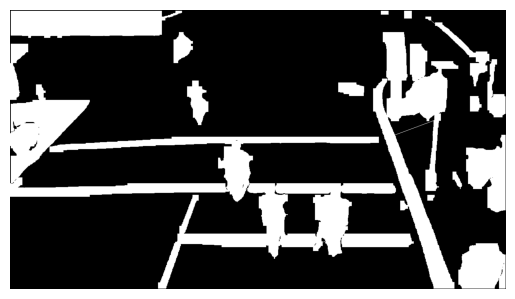

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
result = res[0]
if result.masks:
    # Lấy kích thước ảnh gốc từ kết quả YOLO
    img_h, img_w = result.orig_shape[:2]

    # Tạo ảnh mask trắng đen (black background)
    mask_image = np.zeros((img_h, img_w), dtype=np.uint8)

    for i, mask_points in enumerate(result.masks.xy):
          polygon = np.array(mask_points, np.int32)
          polygon = polygon.reshape((-1, 1, 2))

          # Vẽ mask màu trắng (255) lên ảnh đen
          cv2.fillPoly(mask_image, [polygon], 255)

    # Hiển thị mask
    plt.imshow(mask_image, cmap="gray")
    plt.axis("off")  # Tắt trục tọa độ
    plt.show()


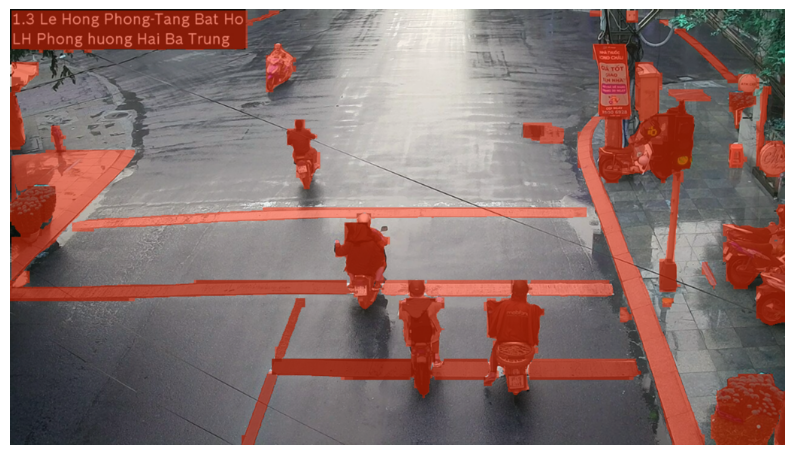

In [ ]:
import matplotlib.pyplot as plt

# Get the first result (assuming single image processing)
img_with_masks = res[0].plot(
    conf=True,       # Hiển thị confidence score (mặc định: True)
    boxes=False,      # Hiển thị bounding boxes (mặc định: True)
    masks=True,      # Hiển thị masks (mặc định: True)
    labels=True,     # Hiển thị nhãn (mặc định: True)
    kpt_line=True,   # Vẽ đường nối keypoints (nếu có)
)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_with_masks)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import json
import os
from PIL import Image
from shapely.geometry import Polygon

def read_labelme_json(json_path):
    """Đọc file JSON LabelMe và trả về danh sách shapes."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data["shapes"]

def is_contained(box1, box2):
    """Kiểm tra xem box2 có nằm hoàn toàn trong box1 không (dùng shapely)."""
    x1_0, y1_0, x2_0, y2_0 = box1  # Class 0
    x1_3, y1_3, x2_3, y2_3 = box2  # Class 2

    # Tạo Polygon từ bounding box
    bb_polygon = Polygon([(x1_0, y1_0), (x2_0, y1_0), (x2_0, y2_0), (x1_0, y2_0)])
    mask_polygon = Polygon([(x1_3, y1_3), (x2_3, y1_3), (x2_3, y2_3), (x1_3, y2_3)])

    return mask_polygon.within(bb_polygon)

def is_above_half(box1, box2):
    """Kiểm tra xem box2 có nằm ở nửa trên của box1 không."""
    x1_0, y1_0, x2_0, y2_0 = box1  # Class 0
    x1_3, y1_3, x2_3, y2_3 = box2  # Class 2

    # Tính chiều cao của box1
    height_0 = y2_0 - y1_0
    half_height_0 = height_0 / 2
    mid_y_0 = y1_0 + half_height_0  # Điểm giữa theo chiều dọc của box1

    # Tính trung điểm theo chiều dọc của box2
    mid_y_2 = (y1_3 + y2_3) / 2

    # Kiểm tra xem trung điểm của box2 có nằm ở nửa trên của box1 không
    return mid_y_2 <= mid_y_0

def get_bbox(shape):
    """Trích xuất tọa độ bounding box từ shape (dạng [[x1,y1], [x2,y2]])."""
    points = shape["points"]
    x1, y1 = points[0]
    x2, y2 = points[1]
    return [min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)]  # Đảm bảo x1 < x2, y1 < y2


def extend_bbox(bbox, image_width, image_height, percentage=0.15):
    """Mở rộng bounding box theo tỷ lệ phần trăm và giới hạn trong kích thước ảnh."""
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    x1 -= width * percentage
    y1 -= height * percentage
    x2 += width * percentage
    y2 += height * percentage

    # Giới hạn tọa độ trong kích thước ảnh
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image_width, x2)
    y2 = min(image_height, y2)

    return [x1, y1, x2, y2]
def crop_and_save(image_path, shapes, output_dir, bb_cls1, output_list):
    """Crop ảnh dựa trên class 0 nếu class 2 nằm trong nó và ở nửa trên, lưu thông tin các class 1, 2, 3 trong extended_bbox_0."""
    image = Image.open(image_path)
    image_width, image_height = image.size  # Get image size
    class_0_shapes = [s for s in shapes if s["label"] == "0"]
    class_1_shapes = [s for s in shapes if s["label"] == "1"]
    class_2_shapes = [s for s in shapes if s["label"] == "2"]
    class_3_shapes = [s for s in shapes if s["label"] == "3"]

    index = 0
    # Danh sách để lưu thông tin tất cả các extended_bbox_0 và dữ liệu liên quan trong cùng một ảnh
    image_data = {
        "file_name": image_path,
        "regions": []  # Mỗi region chứa extended_bbox_0, bboxes, và contained_classes
    }

    for shape_2 in class_2_shapes:
        bbox_2 = get_bbox(shape_2)
        for shape_0 in class_0_shapes:
            bbox_0 = get_bbox(shape_0)
            extended_bbox_0 = extend_bbox(bbox_0, image_width, image_height)  # Extend class 0 box

            # Kiểm tra điều kiện: class 2 nằm trong extended_bbox_0 và ở nửa trên
            if is_contained(extended_bbox_0, bbox_2) and is_above_half(extended_bbox_0, bbox_2):
                # Crop ảnh theo extended_bbox_0
                cropped = image.crop(extended_bbox_0)
                base_name = os.path.splitext(os.path.basename(image_path))[0]
                output_filename = f"{base_name}_crop_{index}.jpg"
                output_path = os.path.join(output_dir, output_filename)
                index += 1

                # Lưu ảnh đã crop
                # cropped.save(output_path)
                output_list.append(cropped)

                # Thu thập thông tin các class 1, 2, 3 nằm trong extended_bbox_0
                contained_classes = []

                # Kiểm tra class 1
                for shape_1 in class_1_shapes:
                    bbox_1 = get_bbox(shape_1)
                    if is_contained(extended_bbox_0, bbox_1):
                        contained_classes.append({
                            "label": "1",
                            "bbox": bbox_1,
                            "shape": shape_1
                        })

                # Kiểm tra class 2 (bao gồm cả bbox_2 hiện tại và các bbox_2 khác)
                for shape_2_inner in class_2_shapes:
                    bbox_2_inner = get_bbox(shape_2_inner)
                    if is_contained(extended_bbox_0, bbox_2_inner):
                        contained_classes.append({
                            "label": "2",
                            "bbox": bbox_2_inner,
                            "shape": shape_2_inner
                        })

                # Kiểm tra class 3
                for shape_3 in class_3_shapes:
                    bbox_3 = get_bbox(shape_3)
                    if is_contained(extended_bbox_0, bbox_3):
                        contained_classes.append({
                            "label": "3",
                            "bbox": bbox_3,
                            "shape": shape_3
                        })

                # Thêm thông tin của region này (extended_bbox_0 và các class liên quan) vào image_data
                image_data["regions"].append({
                    "bboxes_extend": extended_bbox_0,  # Giữ nguyên dạng [x1, y1, x2, y2]
                    "bboxes": bbox_0,  # Giữ nguyên dạng [x1, y1, x2, y2]
                    "contained_classes": contained_classes,  # Các class 1, 2, 3 nằm trong
                })

                break  # Chỉ cần 1 class 0 thỏa mãn cho mỗi class 2

    # Sau khi xử lý tất cả các regions, thêm image_data vào bb_cls1 nếu có region nào được tìm thấy
    if image_data["regions"]:
        bb_cls1.append(image_data)

# Đường dẫn file
img_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328"
output_dir = "/content/drive/MyDrive/aug/crop_v2"  # Thư mục lưu ảnh đã crop

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Khởi tạo list chứa bounding box class 0
bb_cls0 = []
output_list = []
# Lấy danh sách file ảnh
imgs = os.listdir(img_dir)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
image_files = [f for f in imgs if f.lower().endswith(image_extensions)]
from tqdm import tqdm
# Xử lý từng ảnh
for img in tqdm(image_files):
    image_path = os.path.join(img_dir, img)
    json_path = image_path.replace(".jpg", ".json")
    shapes = read_labelme_json(json_path)
    crop_and_save(image_path, shapes, output_dir, bb_cls0, output_list)

print(f"Đã crop và lưu {len(bb_cls0)} ảnh vào thư mục: {output_dir}")

100%|██████████| 700/700 [00:53<00:00, 13.17it/s]

Đã crop và lưu 390 ảnh vào thư mục: /content/drive/MyDrive/aug/crop_v2


In [ ]:
import random

filter_nohelmet = []
for obj in bb_cls0:
    nohelmet_obj = obj.copy()
    regions_without_nohelmet = [
        region for region in obj["regions"]
        if not any(class_obj.get("label") == "1" for class_obj in region.get("contained_classes", []))
    ]

    if regions_without_nohelmet:
        # Tạo danh sách regions mới
        augmented_regions = regions_without_nohelmet.copy()

        # Nếu số lượng regions < 3, thêm regions sao chép để đạt 3 hoặc 4
        if len(augmented_regions) < 3:
            # Quyết định số lượng regions mục tiêu (3 hoặc 4)
            target_count = random.choice([3, 4])

            # Tính số lượng regions cần thêm
            additional_needed = target_count - len(augmented_regions)

            # Thêm regions sao chép ngẫu nhiên
            for _ in range(additional_needed):
                # Chọn ngẫu nhiên một region để sao chép
                region_to_copy = random.choice(regions_without_nohelmet).copy()

                # Thêm vào danh sách regions mới
                augmented_regions.append(region_to_copy)

        nohelmet_obj["regions"] = augmented_regions
        filter_nohelmet.append(nohelmet_obj)
filter_nohelmet[2].get("regions")

[{'bboxes_extend': [537.0524169921875,
   220.2593681335449,
   635.92255859375,
   423.26945571899415],
  'bboxes': [548.4605102539062,
   243.68360900878906,
   624.5144653320312,
   399.84521484375],
  'contained_classes': [{'label': '2',
    'bbox': [585.2379150390625,
     247.80979919433594,
     608.7448120117188,
     272.5826416015625],
    'shape': {'label': '2',
     'points': [[585.2379150390625, 247.80979919433594],
      [608.7448120117188, 272.5826416015625]],
     'group_id': None,
     'description': '',
     'shape_type': 'rectangle',
     'flags': {},
     'mask': None}}]},
 {'bboxes_extend': [537.0524169921875,
   220.2593681335449,
   635.92255859375,
   423.26945571899415],
  'bboxes': [548.4605102539062,
   243.68360900878906,
   624.5144653320312,
   399.84521484375],
  'contained_classes': [{'label': '2',
    'bbox': [585.2379150390625,
     247.80979919433594,
     608.7448120117188,
     272.5826416015625],
    'shape': {'label': '2',
     'points': [[585.237

In [ ]:
len(bb_cls0)

390

In [ ]:
import cv2
import numpy as np
import os
from shapely.geometry import Polygon

# Giả sử 'model' và 'bb_cls0' đã được định nghĩa ở đâu đó trong code của bạn

# Tạo thư mục mask nếu chưa tồn tại
mask_dir = "/content/drive/MyDrive/aug/masks_v2"
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

for i in range(len(bb_cls0)):
    # Dữ liệu bounding box (nhiều bb_cls0)
    file_name = bb_cls0[i].get("file_name")
    res = model(file_name)  # Truyền conf đúng cách
    regions = bb_cls0[i].get("regions")  # Đã sửa lại tên biến cho đúng
    # Giả định result là kết quả từ YOLO
    result = res[0]
    if result.masks:
        # Lấy kích thước ảnh gốc từ kết quả YOLO
        img_h, img_w = result.orig_shape[:2]

        # Tạo ảnh mask trắng đen (black background)
        mask_image = np.zeros((img_h, img_w), dtype=np.uint8)

        for j, mask_points in enumerate(result.masks.xy):  # Sửa lại biến lặp để tránh trùng lặp
            polygon = np.array(mask_points, np.int32)

            # Tạo Polygon từ các điểm của mask
            mask_polygon = Polygon(polygon)

            # Kiểm tra xem mask_polygon có nằm trong bất kỳ bb_cls0 nào không
            for region in regions:
                x_min, y_min, x_max, y_max = region.get("bboxes_extend")
                # Tạo Polygon từ bounding box
                bb_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

                # Nếu mask_polygon nằm hoàn toàn trong bb_polygon thì vẽ
                if mask_polygon.within(bb_polygon):
                    polygon = polygon.reshape((-1, 1, 2))
                    # Vẽ mask màu trắng (255) lên ảnh đen
                    cv2.fillPoly(mask_image, [polygon], 255)
                    break  # Thoát vòng lặp nếu đã tìm thấy một bbox phù hợp

        # Lưu mask vào thư mục mask
        mask_filename = f"{os.path.splitext(os.path.basename(file_name))[0]}.jpg" #Tạo tên file mask từ tên file ảnh gốc
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask_image)


image 1/1 /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328/CAM019_20250326_1051_Nang_30.jpg: 576x1024 86 objects, 97.1ms
Speed: 4.1ms preprocess, 97.1ms inference, 8.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328/CAM019_20250326_1052_Nang_18.jpg: 576x1024 75 objects, 94.2ms
Speed: 4.0ms preprocess, 94.2ms inference, 7.3ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328/CAM019_20250326_1101_Nang_17.jpg: 576x1024 105 objects, 95.9ms
Speed: 4.1ms preprocess, 95.9ms inference, 9.4ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0328/0328/CAM019_20250326_1101_Nang_33.jpg: 576x1024 111 objects, 93.4ms
Speed: 4.1ms preprocess, 93.4ms inference, 9.7ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/drive/MyDrive/AIP4

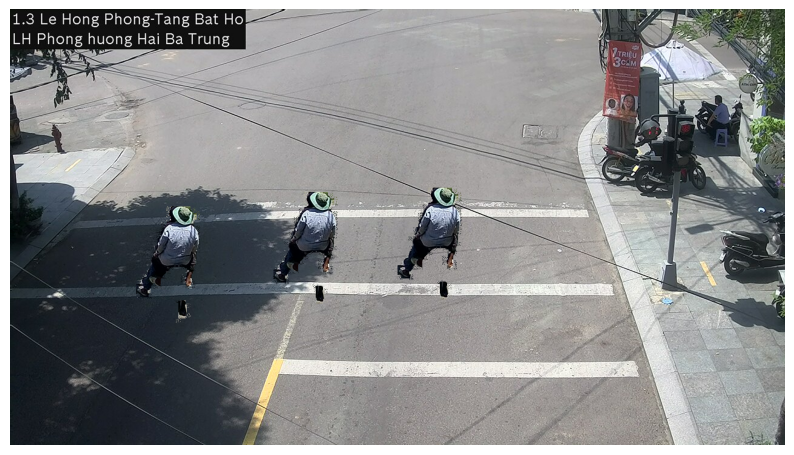

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
def is_collision(box1, box2):
    """
    Kiểm tra xem hai bounding box có giao nhau không
    box1, box2: [x1, y1, x2, y2]
    """
    return not (box1[2] < box2[0] or  # box1 bên trái box2
                box1[0] > box2[2] or  # box1 bên phải box2
                box1[3] < box2[1] or  # box1 bên trên box2
                box1[1] > box2[3])    # box1 bên dưới box2

def place_object_randomly(background, img, mask, regions, max_attempts=50):
    """
    Randomly place segmented objects from an image onto a background image without overlapping bounding boxes.

    Args:
    - background: The background image to place objects on
    - img: The source image containing the objects
    - mask: The segmentation mask of the objects
    - regions: List of region dictionaries containing bboxes_extend, bboxes, and contained_classes
    - max_attempts: Maximum number of attempts to place an object without collision

    Returns:
    - result: Modified background image with objects placed
    - new_regions: Updated region data with new bounding box positions and labels
    """
    result = background.copy()
    bg_height, bg_width = result.shape[:2]
    new_regions = []
    placed_boxes = []  # Lưu trữ các bounding box đã đặt

    for region in regions:
        bbox = region["bboxes_extend"]
        x1, y1, x2, y2 = map(int, bbox)
        obj_width = x2 - x1
        obj_height = y2 - y1

        if (x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0] or
            obj_width <= 0 or obj_height <= 0):
            print(f"Skipping invalid bbox: {bbox}")
            continue

        object_img = img[y1:y2, x1:x2]
        object_mask = mask[y1:y2, x1:x2]

        if object_img.shape[:2] != (obj_height, obj_width):
            print(f"Warning: Cropped size {object_img.shape[:2]} does not match bbox size ({obj_height}, {obj_width})")
            continue

        max_x = int(bg_width * 0.7) - obj_width  # 70% chiều rộng background
        max_y = bg_height - obj_height

        if max_x < 0 or max_y < 0:
            print(f"Object ({obj_width}x{obj_height}) too large for background ({bg_width}x{bg_height})")
            continue

        # Tìm vị trí không bị trùng lặp
        found_valid_position = False
        attempts = 0

        while not found_valid_position and attempts < max_attempts:
            # Random x từ 0 đến 70% width (đã trừ obj_width)
            rand_x = random.randint(0, max(0, max_x))
            # Random y: dịch chuyển ±10 pixel quanh vị trí y1 ban đầu
            max_y_shift = int(obj_height * 0.2)

            # rand_y = random.randint(max(0, y1 - 10), min(max_y, y1 + 10))
            rand_y = random.randint(max(0, y1 - max_y_shift), min(max_y, y1 + max_y_shift))
            # Tạo bounding box mới
            new_box = [rand_x, rand_y, rand_x + obj_width, rand_y + obj_height]

            # Kiểm tra va chạm với các box đã đặt
            has_collision = False
            for placed_box in placed_boxes:
                if is_collision(new_box, placed_box):
                    has_collision = True
                    break

            if not has_collision:
                found_valid_position = True
            else:
                attempts += 1

        if not found_valid_position:
            print(f"Could not find valid position after {max_attempts} attempts, skipping object")
            continue

        # Lưu box đã đặt
        placed_boxes.append(new_box)

        # Xử lý và đặt đối tượng lên background
        _, binary_mask = cv2.threshold(object_mask, 1, 255, cv2.THRESH_BINARY)
        binary_mask_inv = cv2.bitwise_not(binary_mask)
        roi = result[rand_y:rand_y+obj_height, rand_x:rand_x+obj_width]

        if roi.shape[:2] != object_img.shape[:2]:
            print(f"ROI size {roi.shape[:2]} does not match object size {object_img.shape[:2]}")
            continue

        bg_cleared = cv2.bitwise_and(roi, roi, mask=binary_mask_inv)
        object_fg = cv2.bitwise_and(object_img, object_img, mask=binary_mask)
        combined = cv2.add(bg_cleared, object_fg)
        result[rand_y:rand_y+obj_height, rand_x:rand_x+obj_width] = combined

        # Cập nhật thông tin bounding box
        updated_contained_classes = []
        for contained in region["contained_classes"]:
            orig_bbox = contained["bbox"]
            rel_x1 = orig_bbox[0] - x1
            rel_y1 = orig_bbox[1] - y1
            rel_x2 = orig_bbox[2] - x1
            rel_y2 = orig_bbox[3] - y1
            new_x1 = rand_x + rel_x1
            new_y1 = rand_y + rel_y1
            new_x2 = rand_x + rel_x2
            new_y2 = rand_y + rel_y2
            updated_contained_classes.append({
                "label": contained["label"],
                "bbox": [new_x1, new_y1, new_x2, new_y2],
                "shape": contained["shape"]
            })

        orig_bbox_0 = region["bboxes"]
        rel_x1_0 = orig_bbox_0[0] - x1
        rel_y1_0 = orig_bbox_0[1] - y1
        rel_x2_0 = orig_bbox_0[2] - x1
        rel_y2_0 = orig_bbox_0[3] - y1
        new_bbox_0 = [rand_x + rel_x1_0, rand_y + rel_y1_0, rand_x + rel_x2_0, rand_y + rel_y2_0]
        new_extended_bbox = [rand_x, rand_y, rand_x + obj_width, rand_y + obj_height]

        new_regions.append({
            "bboxes_extend": new_extended_bbox,
            "bboxes": new_bbox_0,
            "contained_classes": updated_contained_classes,
        })

    return result, new_regions

# Example usage
background = cv2.imread("background/CAM013_20250326_0933_Nang_57.jpg")
# file_name = bb_cls0[0].get("file_name")
# regions = bb_cls0[0].get("regions")

# Load the mask and the image
mask = cv2.imread(f"/content/drive/MyDrive/aug/masks_v2/{file_name.split('/')[-1]}", cv2.IMREAD_GRAYSCALE)
img = cv2.imread(file_name)

# Ensure mask and img dimensions match
if mask.shape != img.shape[:2]:
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

# Place objects randomly
# result_image = place_object_randomly(background, img, mask, bboxes)
result_image, new_regions = place_object_randomly(background, img, mask, regions)

# Convert BGR to RGB for matplotlib
output_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import json
import base64
def convert_to_labelme_json(background_path, new_regions, output_json_path, result_image=None):
    output_data = {
        "version": "5.6.1",
        "flags": {},
        "shapes": [],
        "imagePath": background_path.split("/")[-1],
        "imageData": "",
        "imageHeight": None,
        "imageWidth": None
    }

    # Thay đổi ở đây: dùng result_image thay vì đọc file
    if result_image is not None:
        _, encoded_image = cv2.imencode('.jpg', result_image)
        image_data = base64.b64encode(encoded_image).decode('utf-8')
        output_data["imageData"] = image_data
    else:
        with open(background_path, "rb") as image_file:
            image_data = base64.b64encode(image_file.read()).decode('utf-8')
        output_data["imageData"] = image_data

    # Phần còn lại giữ nguyên
    if result_image is not None:
        output_data["imageHeight"], output_data["imageWidth"] = result_image.shape[:2]

    for region in new_regions:
        bboxes = region["bboxes"]
        shape_class_0 = {
            "label": "0",
            "points": [[bboxes[0], bboxes[1]], [bboxes[2], bboxes[3]]],
            "group_id": None,
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": None
        }
        output_data["shapes"].append(shape_class_0)

        for contained in region["contained_classes"]:
            contained_bbox = contained["bbox"]
            shape = {
                "label": contained["label"],
                "points": [[contained_bbox[0], contained_bbox[1]], [contained_bbox[2], contained_bbox[3]]],
                "group_id": None,
                "description": "",
                "shape_type": "rectangle",
                "flags": {},
                "mask": None
            }
            output_data["shapes"].append(shape)

    with open(output_json_path, 'w') as f:
        json.dump(output_data, f, indent=2)


    if result_image is not None:
        output_image_path = os.path.splitext(output_json_path)[0] + ".jpg"
        cv2.imwrite(output_image_path, result_image)

# Example usage:
# Assuming you have run place_object_randomly and have the results


In [ ]:

background_path = "default/CAM024_20250213_1114_Nang_57.jpg"
moto = random.choice(bb_cls0)
background = cv2.imread(background_path)
file_name = moto.get("file_name")
regions = moto.get("regions")

# Load the mask and the image
mask = cv2.imread(f"/content/drive/MyDrive/aug/masks/{file_name.split('/')[-1]}", cv2.IMREAD_GRAYSCALE)
img = cv2.imread(file_name)

# Ensure mask and img dimensions match
if mask.shape != img.shape[:2]:
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

# Place objects randomly
# result_image = place_object_randomly(background, img, mask, bboxes)
result_image, new_regions = place_object_randomly(background, img, mask, regions)


result_image, new_regions = place_object_randomly(background, img, mask, regions)
convert_to_labelme_json(background_path, new_regions, "output_1.json", result_image=result_image)

LabelMe JSON saved to output_1.json
Result image saved to output_1.jpg


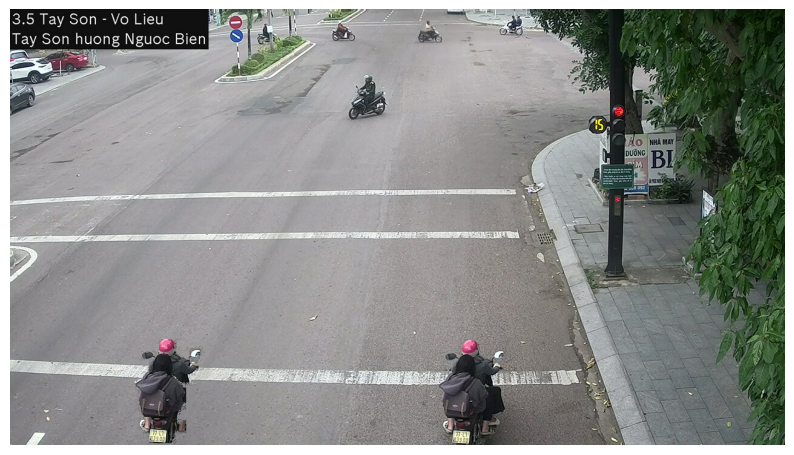

In [ ]:
# Convert BGR to RGB for matplotlib
output_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(output_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
############### FINAL ##############
import cv2
all_back_ground = os.listdir("/content/drive/MyDrive/aug/background")
from tqdm import tqdm
index = 222
for moto in tqdm(filter_nohelmet):
  index += 1
  # moto = random.choice(bb_cls0)
  background_path =  random.choice(all_back_ground)
  background = cv2.imread(f"/content/drive/MyDrive/aug/background/{background_path}")
  file_name = moto.get("file_name")
  regions = moto.get("regions")

  # Load the mask and the image
  mask = cv2.imread(f"/content/drive/MyDrive/aug/masks_v2/{file_name.split('/')[-1]}", cv2.IMREAD_GRAYSCALE)
  img = cv2.imread(file_name)

  # Ensure mask and img dimensions match
  if mask.shape != img.shape[:2]:
      mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

  # Place objects randomly
  # result_image = place_object_randomly(background, img, mask, bboxes)

  result_image, new_regions = place_object_randomly(background, img, mask, regions)
  convert_to_labelme_json(background_path, new_regions, f"/content/drive/MyDrive/aug/augment_result_mask_2/aug_mixup_{index:04d}_{file_name.split('/')[-1].replace('.jpg', '.json')}", result_image=result_image)

  6%|▋         | 14/222 [00:09<02:01,  1.72it/s]

Could not find valid position after 50 attempts, skipping object


 24%|██▍       | 54/222 [00:37<01:44,  1.61it/s]

Could not find valid position after 50 attempts, skipping object


 25%|██▍       | 55/222 [00:37<01:53,  1.47it/s]

Could not find valid position after 50 attempts, skipping object


 33%|███▎      | 73/222 [00:46<01:13,  2.03it/s]

Could not find valid position after 50 attempts, skipping object


 34%|███▍      | 75/222 [00:46<01:05,  2.25it/s]

Could not find valid position after 50 attempts, skipping object


 44%|████▎     | 97/222 [00:57<01:03,  1.98it/s]

Could not find valid position after 50 attempts, skipping object


 47%|████▋     | 104/222 [01:00<00:55,  2.13it/s]

Could not find valid position after 50 attempts, skipping object


 48%|████▊     | 107/222 [01:02<00:55,  2.06it/s]

Could not find valid position after 50 attempts, skipping object


 67%|██████▋   | 149/222 [01:22<00:38,  1.89it/s]

Could not find valid position after 50 attempts, skipping object


 82%|████████▏ | 182/222 [01:38<00:17,  2.29it/s]

Could not find valid position after 50 attempts, skipping object


 96%|█████████▌| 213/222 [01:52<00:03,  2.37it/s]

Could not find valid position after 50 attempts, skipping object


 98%|█████████▊| 217/222 [01:54<00:01,  2.56it/s]

Could not find valid position after 50 attempts, skipping object


100%|██████████| 222/222 [01:56<00:00,  1.90it/s]


In [ ]:
sorted(os.listdir("/content/drive/MyDrive/aug/augment_result_mask_2/"))

['aug_mixup_0001_CAM019_20250326_1126_Nang_31.jpg',
 'aug_mixup_0001_CAM019_20250326_1126_Nang_31.json',
 'aug_mixup_0002_CAM019_20250326_1135_Nang_17.jpg',
 'aug_mixup_0002_CAM019_20250326_1135_Nang_17.json',
 'aug_mixup_0003_CAM019_20250326_1626_None_02.jpg',
 'aug_mixup_0003_CAM019_20250326_1626_None_02.json',
 'aug_mixup_0004_CAM019_20250326_1638_None_36.jpg',
 'aug_mixup_0004_CAM019_20250326_1638_None_36.json',
 'aug_mixup_0005_CAM019_20250326_1638_None_53.jpg',
 'aug_mixup_0005_CAM019_20250326_1638_None_53.json',
 'aug_mixup_0006_CAM019_20250328_1104_Nang_56.jpg',
 'aug_mixup_0006_CAM019_20250328_1104_Nang_56.json',
 'aug_mixup_0007_CAM019_20250328_1128_Nang_15.jpg',
 'aug_mixup_0007_CAM019_20250328_1128_Nang_15.json',
 'aug_mixup_0008_CAM021_20250326_0945_Nang_37.jpg',
 'aug_mixup_0008_CAM021_20250326_0945_Nang_37.json',
 'aug_mixup_0009_CAM021_20250326_1001_Nang_33.jpg',
 'aug_mixup_0009_CAM021_20250326_1001_Nang_33.json',
 'aug_mixup_0010_CAM021_20250326_1002_Nang_37.jpg',
 'a

In [ ]:
rm -rf /content/drive/MyDrive/aug/augment_result_mask_2


image 1/1 /content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/26_06_recheck/CAM024_20250213_1114_Nang_57.jpg: 576x1024 62 objects, 9010.5ms
Speed: 13.6ms preprocess, 9010.5ms inference, 550.8ms postprocess per image at shape (1, 3, 576, 1024)


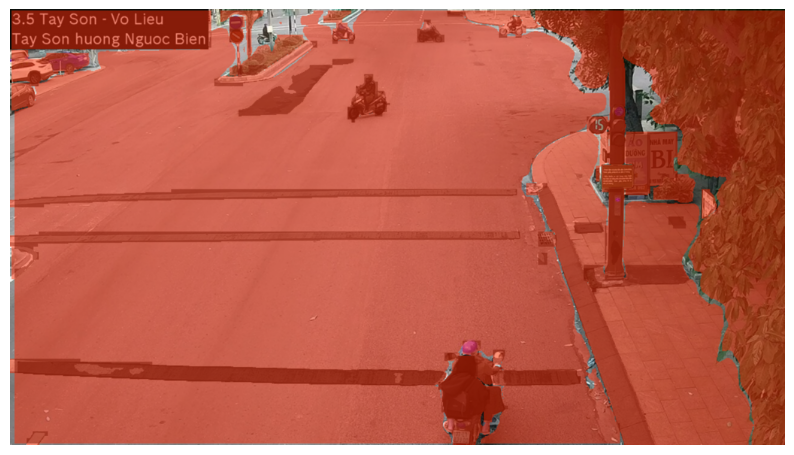

In [ ]:
import matplotlib.pyplot as plt
res = model(moto.get("file_name"))
# Get the first result (assuming single image processing)
img_with_masks = res[0].plot(
    conf=True,       # Hiển thị confidence score (mặc định: True)
    boxes=False,      # Hiển thị bounding boxes (mặc định: True)
    masks=True,      # Hiển thị masks (mặc định: True)
    labels=True,     # Hiển thị nhãn (mặc định: True)
    kpt_line=True,   # Vẽ đường nối keypoints (nếu có)
)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_with_masks)
plt.axis('off')  # Hide axes
plt.show()

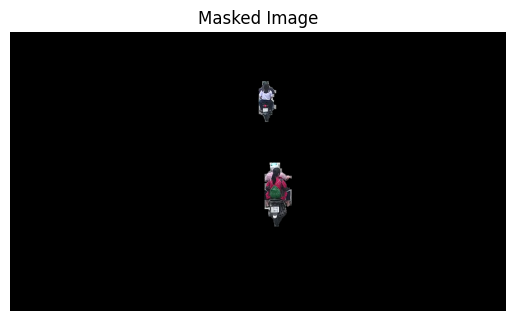

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def visualize_masked_image(file_name):
    """Visualize ảnh gốc nhân với mask."""
    mask_file_name = file_name.replace("/default/", "/masks/")

    if not os.path.exists(mask_file_name):
        print(f"Mask file not found: {mask_file_name}")
        return

    mask = cv2.imread(mask_file_name, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.imread(file_name)

    if img is None:
        print(f"Image file not found: {file_name}")
        return
    if mask is None:
        print(f"Mask file could not be read: {mask_file_name}")
        return

    # Ensure mask has the same dimensions as the image
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Convert mask to 3-channel
    mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Normalize mask to 0-1 range
    normalized_mask = mask_3channel / 255.0

    # Apply mask to image
    masked_img = img * normalized_mask

    # Display the result using matplotlib
    plt.imshow(cv2.cvtColor(masked_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title("Masked Image")
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage (replace with your file name)
file_name = bb_cls0[1].get("file_name") # Assumes bb_cls0 is defined
visualize_masked_image(file_name)